# Flight price prediction

The aim of this project is to build a model for predicting air ticket prices. I will use machine learning tools for this purpose.
This data comes from the kaggle.com website and consisted of 3 files:
- business - data with business class tickets
- economy - data with economy class tickets
- Clean_Dataset - combined processed data ready for analysis.
For a better understanding of the Data Science topic, I independently prepared data from the business and economy files so that their structure was analogous to the Clean_Dataset file.
This data pertains exclusively to flights between Indian cities and operated by several airlines. However, their vast quantity and detail might be interesting for examining the factors influencing ticket prices.

### Research questions:
1. Does the flight class have a significant impact on the ticket price?
2. How does the airline affect the price?
3. Does the number of layovers matter?
4. What impact does flight duration have on the price?
5. Does the number of days until departure affect the price?
6. How is the distribution of tickets across classes?
7. How does the arrival/departure time influence the price?
8. What is the price variation based on different factors?

### Columns in final dataframe:
- **airline** - name of airline ('SpiceJet', 'AirAsia', 'Vistara', 'GO FIRST', 'Indigo', 'Air India')
- **flight** - flight number
- **source_city** - arrival city ('Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai')
- **departure_time** - time of day ('Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night')
- **stops** - number of layovers (0, 1, 2+)
- **arrival_time** - time of day ('Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night')
- **destination_city** - destination city ('Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai')
- **class** - class of flight (economy, business)
- **duration** - time of flight in hours
- **days_left** - ticket price depending on the days to departure
- **price_pln** - ticket price (to better understanding in PLN)

## Importing libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing business class data




In [4]:
business_data = pd.read_csv("/content/drive/MyDrive/business.csv")

## Importing economy class data

In [5]:
economy_data = pd.read_csv("/content/drive/MyDrive/economy.csv")

In [6]:
business_data['class'] = "Business" # adding column "class" to recognize class after merge data

In [7]:
business_data.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",Business
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",Business
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",Business
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",Business
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",Business


In [8]:
economy_data['class'] = "Economy" # adding column "class" to recognize class after merge data

In [9]:
economy_data.head() # both files have the same structure so is possible to merge this datasets

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


In [10]:
df = pd.concat([economy_data, business_data]) # merging datasets "business" and "economy"

In [11]:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


## Modifying data to match the structure from the 'Clean dataset' file.

In [12]:
import re

def check_time_format(df):
    # Pattern for the time format
    pattern = re.compile(r'^\d{1,2}h \d{2}m$')

    # Filter values that don't match the pattern
    mismatched_values = df["time_taken"][~df["time_taken"].str.match(pattern)]

    return mismatched_values.tolist()

# Use the function and print non-matching values
non_matching_values = check_time_format(df)
if non_matching_values:
    print("Values not matching the pattern:", non_matching_values)
else:
    print("All values match the pattern.")




Values not matching the pattern: ['1.03h m', '1.02h m', '1.03h m', '1.01h m']


Funtion checked that is 2 type of format data in column "time_take"

In [13]:
def convert_to_decimal(time_str):
    if "h m" in time_str:  # Check if the format is "1.03h m"
        time_parts = time_str.replace('h m', '').split('.')
        hours = int(time_parts[0])
        minutes = int(time_parts[1])
        return round(hours + minutes / 60.0, 2)
    else:  # Default format "03h 45m"
        hours, minutes = map(int, time_str.replace('h', '').replace('m', '').split())
        return round(hours + minutes / 60.0, 2)


In [14]:
df["duration"] = df["time_taken"].apply(convert_to_decimal)

Function changed 2 format of hours to float number

In [15]:
df["date"] = pd.to_datetime(df["date"], format='%d-%m-%Y')

In [16]:
# Data for comparison
target_date = pd.Timestamp('2022-02-10')

# Function to calculate the number of days to the target date
def days_to_target(row_date, target_date):
    delta = row_date - target_date
    return delta.days

# Applying the function to the 'date' column and saving the results in a new 'days' column
df['days'] = df['date'].apply(lambda x: days_to_target(x, target_date))


In [17]:
df["stop"].unique()

array(['non-stop ',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Indore\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '2+-stop',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Lucknow\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GOP\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Raipur\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Nagpur\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Surat\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia STV\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t

In [18]:
def create_stop_2_column(df):
    # Function to map the 'stop' column values to a new format
    def map_stops(word):
        # Check if the word is a string
        if isinstance(word, str):
            # Map 'non-stop' to 'zero'
            if 'non-stop' in word:
                return 'zero'
            # Map '1-stop' to 'one'
            elif '1-stop' in word:
                return 'one'
            # Map '2+-stop' to 'two_plus'
            elif '2+-stop' in word:
                return 'two_plus'
        # Return None for values that don't match any of the above conditions
        return None

    # Apply the mapping function to the 'stop' column and store the results in a new column 'stop_2'
    df['stop_2'] = df['stop'].apply(map_stops)

Function transforms datas in column stop and creating column stop_2 with information about number of stop: [zero, one, two_plus]

In [19]:
create_stop_2_column(df)

In [20]:
def categorize_time(time_str):
    # Convert the hour to an integer
    hour = int(time_str.split(":")[0])

    # Segment into times of day
    if 0 <= hour < 4:
        return 'Late_Night'
    elif 4 <= hour < 8:
        return 'Early_Morning'
    elif 8 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'


In [21]:
df['departure_time'] = df['dep_time'].apply(categorize_time) # applying the function
df["arrival_time"] = df['arr_time'].apply(categorize_time) # applying the function

In [22]:
df["price"] = df["price"].str.replace(",", "").astype(float) # changing "price" column format to float

In [23]:
# exchange rate INR-PLN to better understand price for Polish projects readers
inr_pln_exchange = 0.05

In [24]:
# Creating a 'price_pln' column as a result of multiplying the 'price' column by 'inr_pln_exchange'
df["price_pln"] = df["price"] * inr_pln_exchange

In [25]:
# Combining 'ch_code' and 'num_code' with a dash to make a new 'flight' column
df["flight"] = df["ch_code"].astype(str) + "-" + df["num_code"].astype(str)

In [26]:
# rename columns to clean_dataset schema
rename_column = {"from" : "source_city", "to" : "destination_city", "stop_2" : "stops", "days" : "days_left"}

In [27]:
df.rename(columns=rename_column, inplace=True)

In [28]:
df.head()

,date,airline,ch_code,num_code,dep_time,source_city,time_taken,stop,arr_time,destination_city,price,class,duration,days_left,stops,departure_time,arrival_time,price_pln,flight
0,2022-02-11,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,5953.0,Economy,2.17,1,zero,Evening,Night,297.65,SG-8709
1,2022-02-11,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,5953.0,Economy,2.33,1,zero,Early_Morning,Morning,297.65,SG-8157
2,2022-02-11,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,5956.0,Economy,2.17,1,zero,Early_Morning,Early_Morning,297.80,I5-764
3,2022-02-11,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,5955.0,Economy,2.25,1,zero,Morning,Afternoon,297.75,UK-995
4,2022-02-11,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,5955.0,Economy,2.33,1,zero,Morning,Morning,297.75,UK-963


In [29]:
choosen_column = ["airline", "flight", "source_city", "departure_time", "stops", "arrival_time", "destination_city", "class", "duration", "days_left", "price_pln"]

In [30]:
df = df[choosen_column]

In [31]:
df = df[~df['airline'].isin(['StarAir', 'Trujet'])] # airline deleted for data irrelevance (to little this airlines data)

In [32]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price_pln
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,297.65
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,297.65
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,297.80
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,297.75
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,297.75


Dataset ready to analysis

In [33]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique value for {column} is {unique_values}")
    print("-" * 100)

Unique value for airline is ['SpiceJet' 'AirAsia' 'Vistara' 'GO FIRST' 'Indigo' 'Air India']
----------------------------------------------------------------------------------------------------
Unique value for flight is ['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
----------------------------------------------------------------------------------------------------
Unique value for source_city is ['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
----------------------------------------------------------------------------------------------------
Unique value for departure_time is ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
----------------------------------------------------------------------------------------------------
Unique value for stops is ['zero' 'one' 'two_plus']
----------------------------------------------------------------------------------------------------
Unique value for arrival_time is ['Night' 'Morning' 'Early

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300159 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300159 non-null  object 
 1   flight            300159 non-null  object 
 2   source_city       300159 non-null  object 
 3   departure_time    300159 non-null  object 
 4   stops             300159 non-null  object 
 5   arrival_time      300159 non-null  object 
 6   destination_city  300159 non-null  object 
 7   class             300159 non-null  object 
 8   duration          300159 non-null  float64
 9   days_left         300159 non-null  int64  
 10  price_pln         300159 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 27.5+ MB


Very good quality data - no missing value

In [35]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price_pln           0
dtype: int64

No null values

In [36]:
print(df['airline'].value_counts())

Vistara      127859
Air India     80894
Indigo        43120
GO FIRST      23177
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64


In [37]:
print(df['airline'].value_counts(normalize=True)*100)

Vistara      42.597090
Air India    26.950383
Indigo       14.365720
GO FIRST      7.721574
AirAsia       5.363158
SpiceJet      3.002076
Name: airline, dtype: float64


Over 65% of the tickets are from two airlines

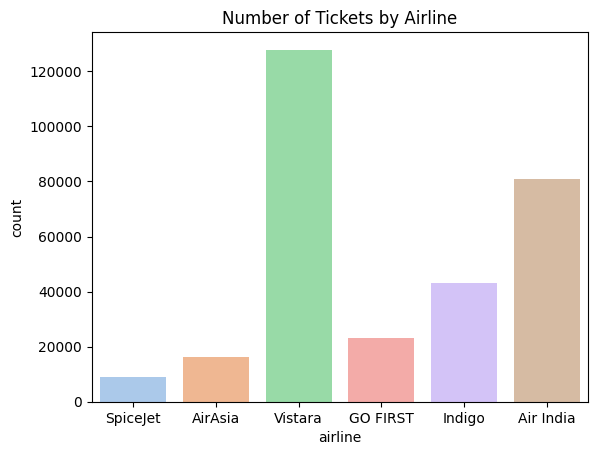

In [39]:
sns.countplot(data=df, x="airline", palette="pastel")
plt.title("Number of Tickets by Airline")
plt.show()

Overwhelming part of records contains 3 airlines: Visatra, Air India, Indigo.

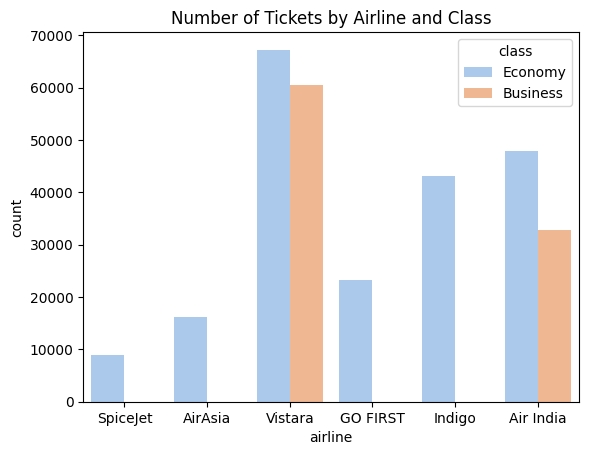

In [40]:
sns.countplot(data=df, x="airline", palette="pastel", hue="class")
plt.title("Number of Tickets by Airline and Class")
plt.show()

Countplot divided into classes: economy and business. Only 2 lines have offers in the business class: Vistara i AirIndia.

<Axes: xlabel='duration', ylabel='price_pln'>

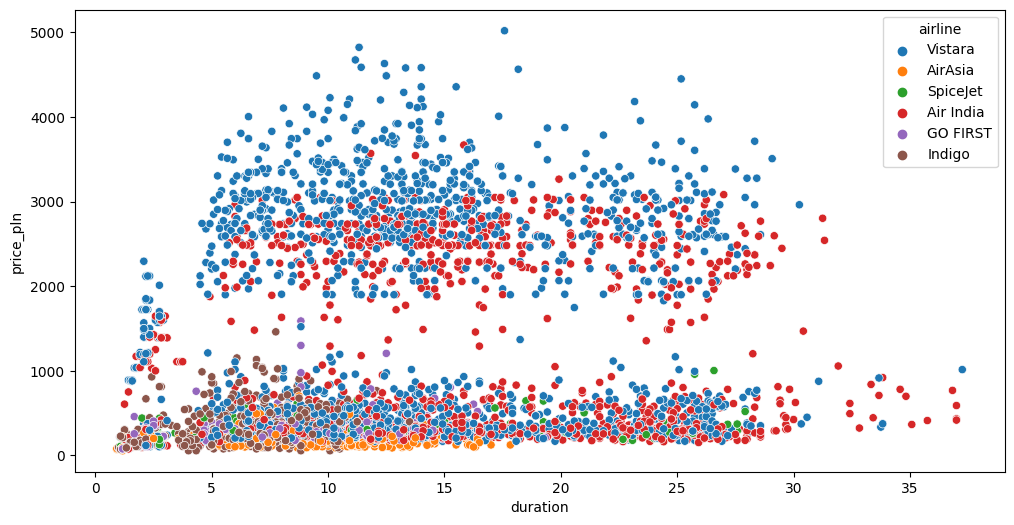

In [44]:
df_sample = df.sample(n=5000) # sample to better visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_sample, x="duration", y="price_pln", hue='airline')

Plot shows that Air India and Vistara has more long and expensive flight. Despite the lack of ticket class labeling on the chart, two distinct groups of tickets can be clearly observed. The group above 2000 PLN is most likely business class tickets.

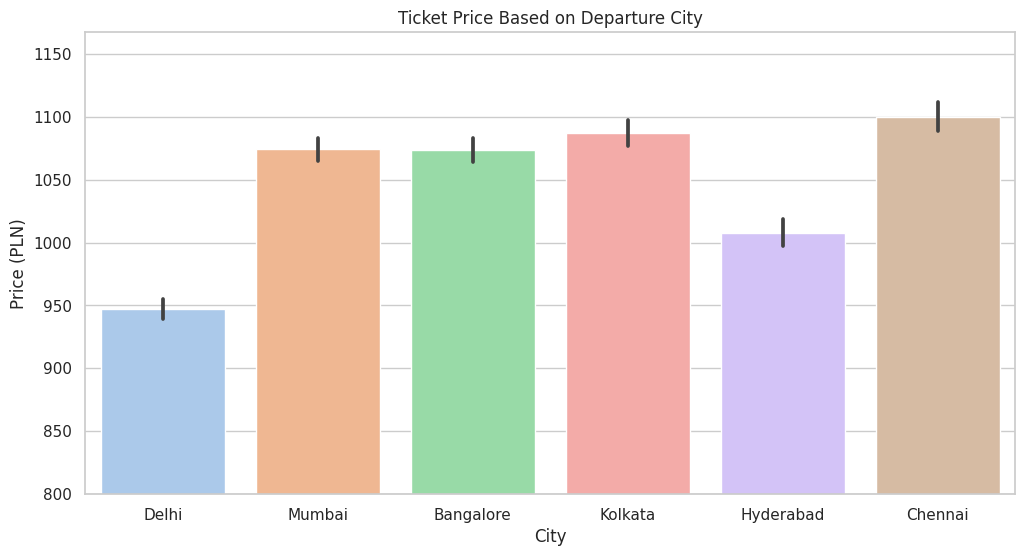

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='source_city', y='price_pln', data=df, palette="pastel")

# Setting the title of the plot
plt.title('Ticket Price Based on Departure City')

# Setting the label for the x-axis
plt.xlabel('City')

# Setting the label for the y-axis
plt.ylabel('Price (PLN)')

# Setting the y-axis limits
plt.ylim(800, None)

# Displaying the plot
plt.show()



The chart shows similar prices for most departure cities. Only flights from Delhi and Hyderabad have noticeably lower fares.

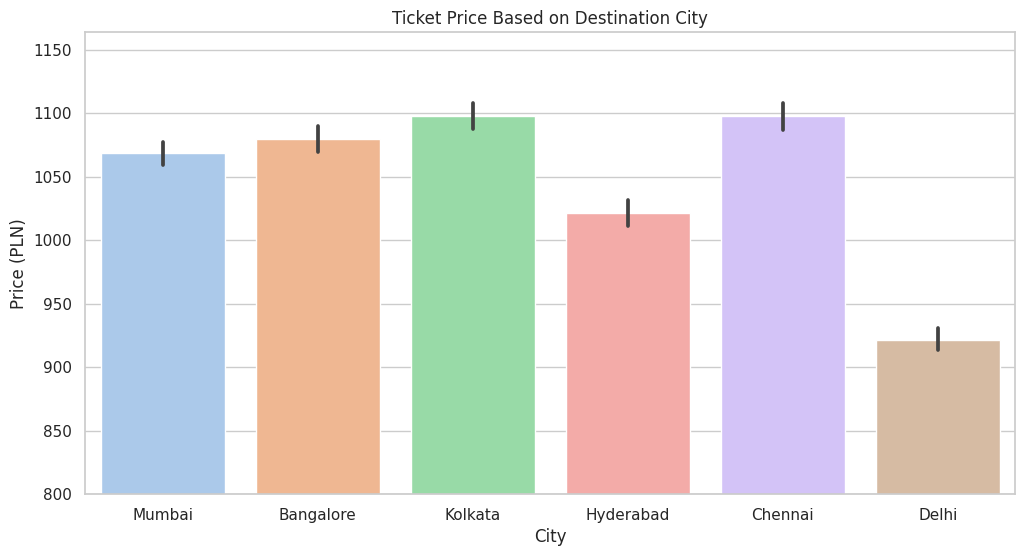

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='destination_city', y='price_pln', data=df, palette="pastel")

# Setting the title of the plot
plt.title('Ticket Price Based on Destination City')

# Setting the label for the x-axis
plt.xlabel('City')

# Setting the label for the y-axis
plt.ylabel('Price (PLN)')

# Setting the y-axis limits
plt.ylim(800, None)

# Displaying the plot
plt.show()



Observations are similar to the previous chart.

In [ ]:
def prepare_route_data(df):
    # Creating a route column
    routes = df[["source_city", "destination_city", "price_pln"]].copy()
    routes["route"] = routes["source_city"] + "-" + routes["destination_city"]

    # Calculating the average price for each route
    average_route_price = routes.groupby('route')['price_pln'].mean().reset_index()

    # Sorting routes so that they are paired
    average_route_price['sort_key'] = average_route_price['route'].apply(lambda x: tuple(sorted(x.split('-'))))
    average_route_price = average_route_price.sort_values(by=['sort_key', 'route'], ascending=[True, False])

    # Removing the sort_key column and rounding the price values to 2 decimal places
    average_route_price = average_route_price.drop(columns='sort_key').reset_index(drop=True)
    average_route_price['price_pln'] = average_route_price['price_pln'].round(2)

    return average_route_price

# Using the function
paired_routes = prepare_route_data(df)
paired_routes

,route,price_pln
0,Chennai-Bangalore,1254.09
1,Bangalore-Chennai,1166.09
2,Delhi-Bangalore,894.01
3,Bangalore-Delhi,886.17
4,Hyderabad-Bangalore,1067.36
5,Bangalore-Hyderabad,1061.21
6,Kolkata-Bangalore,1137.24
7,Bangalore-Kolkata,1174.91
8,Mumbai-Bangalore,1157.39
9,Bangalore-Mumbai,1156.36


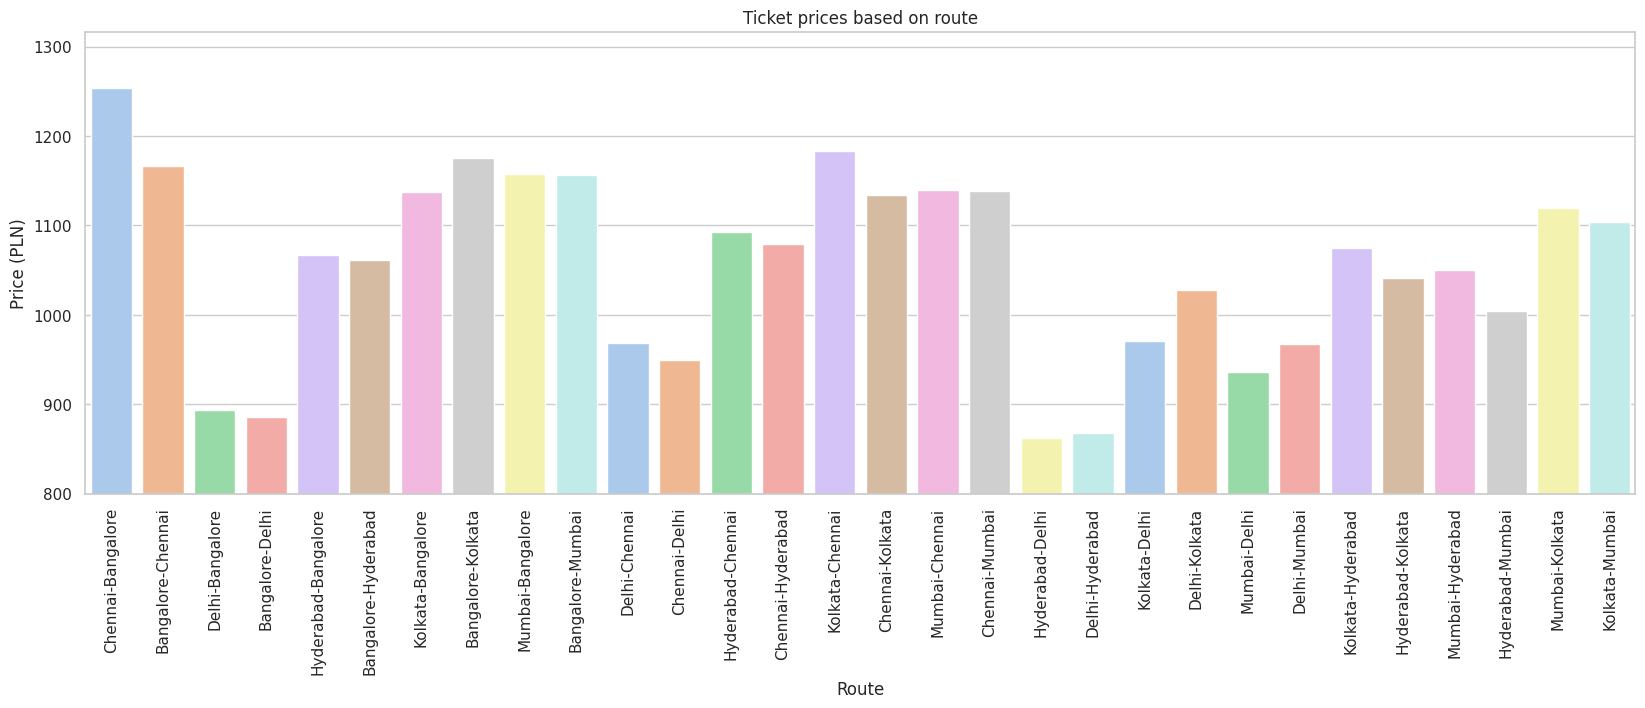

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x='route', y='price_pln', data=paired_routes, palette="pastel")

# Setting the title of the plot
plt.title('Ticket prices based on route')
# Setting the label for the x-axis
plt.xlabel('Route')
# Setting the label for the y-axis
plt.ylabel('Price (PLN)')
# Rotating the x-axis labels for better readability
plt.xticks(rotation=90)
# Setting the y-axis limit to start from 800
plt.ylim(800, None)
# Displaying the plot
plt.show()

There is a significant variation in ticket prices based on the route, ranging from 862 PLN to 1254 PLN. Pairs of the same cities have similar prices.

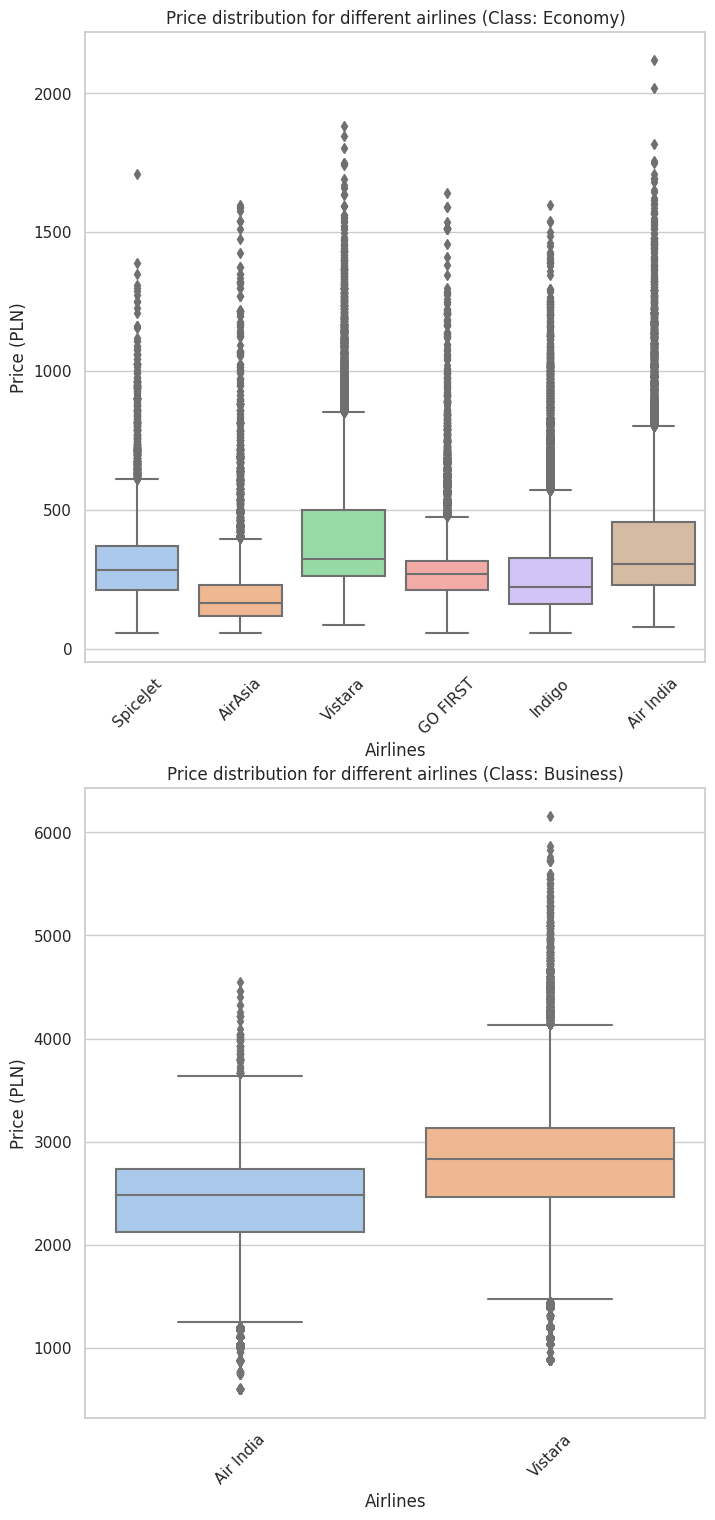

In [ ]:
# Filter df to only include rows with class "Economy"
filtered_economy_df = df[df["class"] == "Economy"]
filtered_business_df = df[df["class"] == "Business"]

plt.figure(figsize = (8,18))

# Plot for "Economy" class
plt.subplot(2,1,1)
sns.set(style="whitegrid")
sns.boxplot(x='airline', y='price_pln', data=filtered_economy_df, palette="pastel")
plt.title('Price distribution for different airlines (Class: Economy)')
plt.xticks(rotation=45)
plt.xlabel('Airlines')
plt.ylabel('Price (PLN)')

# Plot for "Business" class
plt.subplot(2,1,2)
sns.set(style="whitegrid")
sns.boxplot(x='airline', y='price_pln', data=filtered_business_df, palette="pastel")
plt.title('Price distribution for different airlines (Class: Business)')
plt.xticks(rotation=45)
plt.xlabel('Airlines')
plt.ylabel('Price (PLN)')

plt.show()

Vistara and Air India have the most dispersed prices. However, Vistara has a more significant dispersion and higher prices in both economy and business classes. Additionally, it is evident that AirAsia and Indigo are budget airlines with a small price dispersion

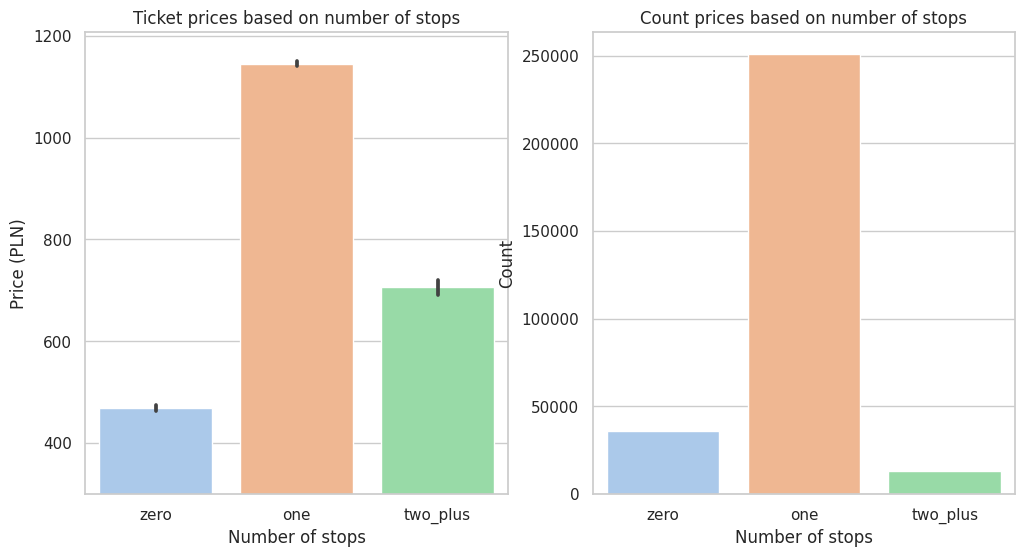

In [ ]:
plt.figure(figsize=(12, 6))

# Plot for ticket prices based on number of stops
plt.subplot(1,2,1)
sns.barplot(x='stops', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on number of stops')
plt.xlabel('Number of stops')
plt.ylabel('Price (PLN)')
plt.ylim(300, None)

# Plot for count of each stop category
plt.subplot(1,2,2)
sns.countplot(data=df, x="stops", palette="pastel")
plt.title('Count prices based on number of stops')
plt.xlabel('Number of stops')
plt.ylabel('Count')

plt.show()

Tickets with one layover are definitely the most expensive. This is likely due to the fact that journeys with one layover are usually on longer routes, whereas multiple layovers significantly reduce travel comfort and decrease customer interest in such a journey.

<ipython-input-153-b9df4c49a6d8>:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='days_left', y='price_pln', data=avg_prices_days_left, palette="pastel", marker="o")


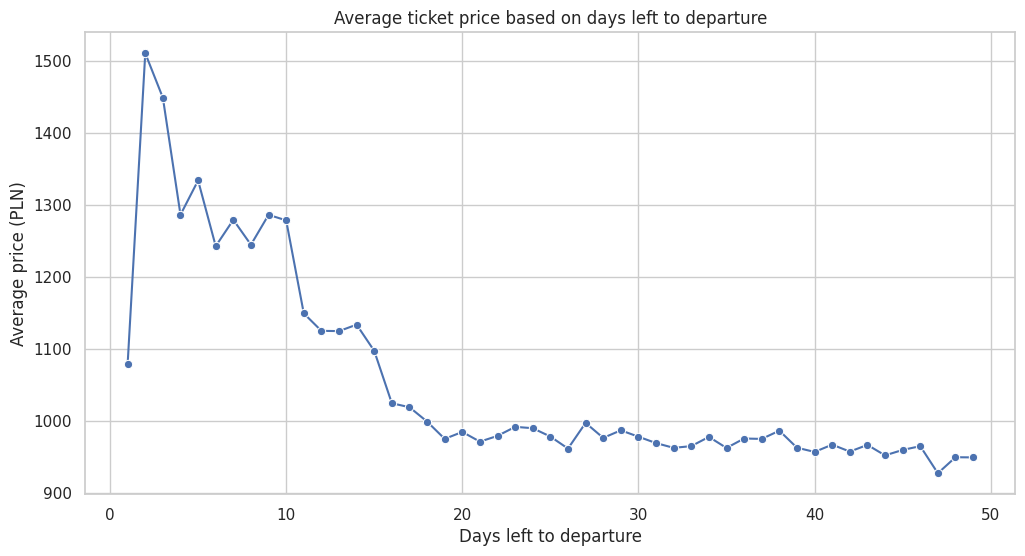

In [ ]:
# Calculate the average price for each 'days_left' value
avg_prices_days_left = df.groupby('days_left')['price_pln'].mean().reset_index()

# Plot a line chart
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(x='days_left', y='price_pln', data=avg_prices_days_left, palette="pastel", marker="o")
plt.title('Average ticket price based on days left to departure')
plt.xlabel('Days left to departure')
plt.ylabel('Average price (PLN)')
plt.grid(True)
plt.show()

The ticket prices, depending on the days until departure, clearly show a downward trend. The most expensive tickets are 2 days before the journey, after which the prices almost linearly decrease. A noticeable exception is the ticket price a day before departure - the average price is comparable to a departure scheduled about 15 days ahead.

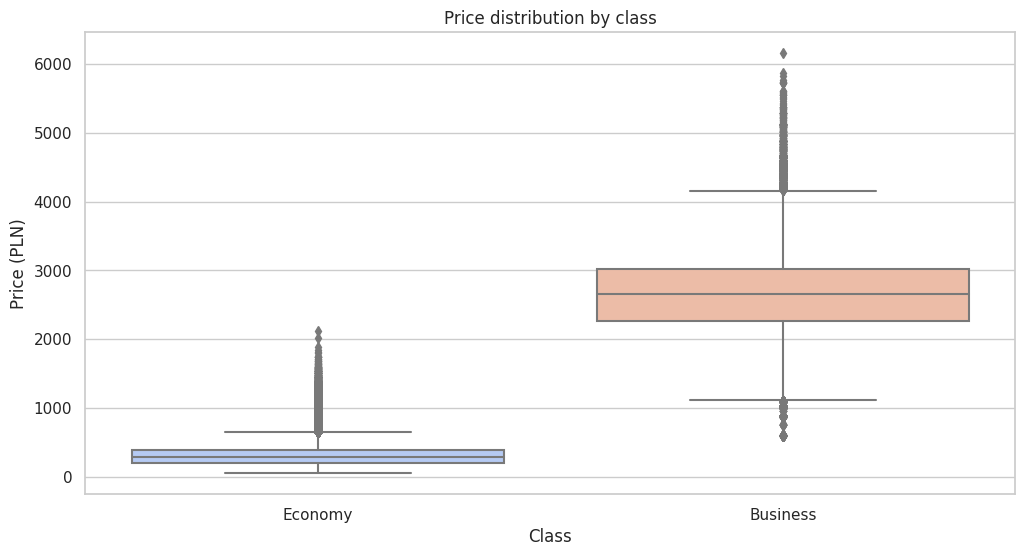

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='price_pln', data=df, palette="coolwarm")
plt.title('Price distribution by class')
plt.xlabel('Class')
plt.ylabel('Price (PLN)')
plt.show()

The flight class has a significant impact on the ticket price as well as the price dispersion. The median for the economy class is 400 PLN, and the deviations are relatively small (the height of the block in the chart is 200 PLN), whereas for the business class, it's over 2500 PLN (the height of the block in the chart is about 800 PLN)

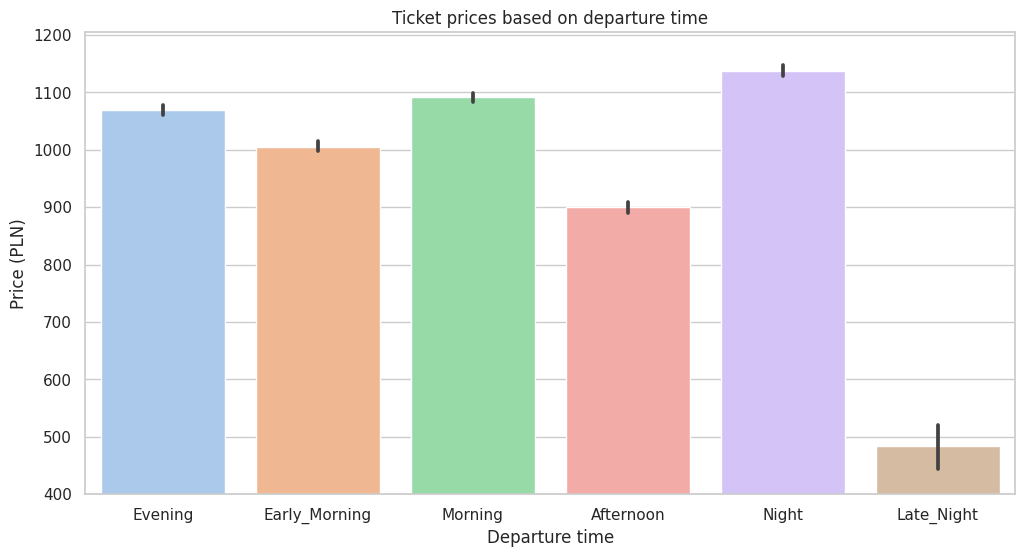

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='departure_time', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on departure time')
plt.xlabel('Departure time')
plt.ylabel('Price (PLN)')
plt.ylim(400, None)
plt.show()

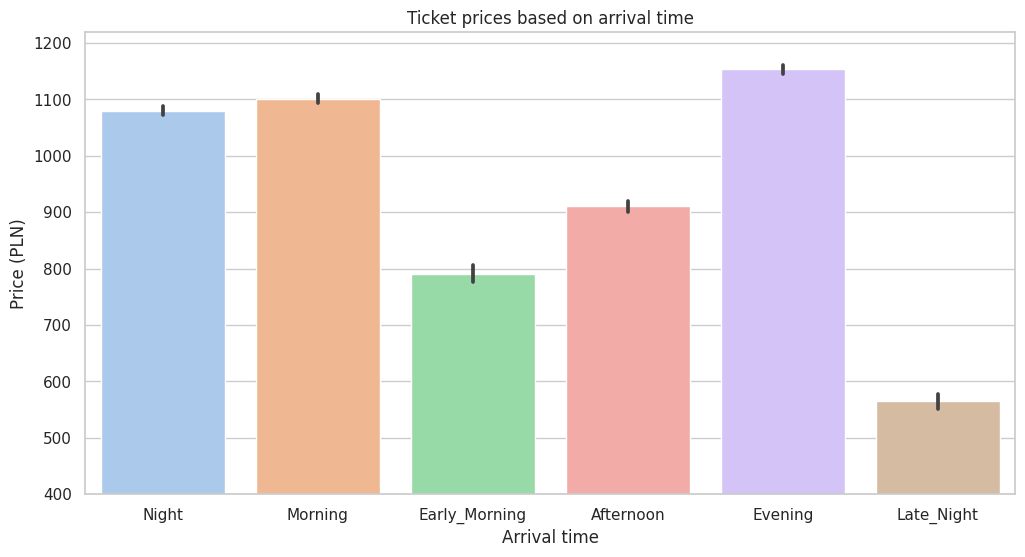

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='arrival_time', y='price_pln', data=df, palette="pastel")
plt.title('Ticket prices based on arrival time')
plt.xlabel('Arrival time')
plt.ylabel('Price (PLN)')
plt.ylim(400, None)
plt.show()

On both charts, it's evident that for both arrival and departure times, late at night ticket prices are decidedly the cheapest. This might be due to the potential higher cost and inconvenience of reaching the airport at a late hour, as well as the challenge of aligning the flight with accommodation. Arriving late in the evening is also cheaper than other times since the passenger has limited time on the day of arrival for handling matters or resting and might require booking an additional night's accommodation

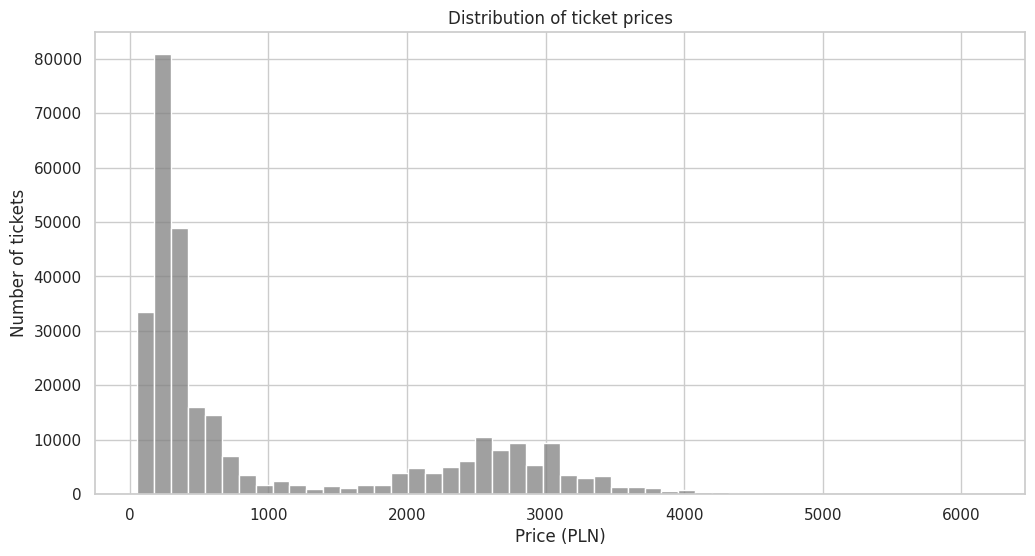

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['price_pln'], bins=50, color="gray")
plt.title('Distribution of ticket prices')
plt.xlabel('Price (PLN)')
plt.ylabel('Number of tickets')
plt.show()

The chart shows two peaks. In the first one, from 0 to 1000 PLN, there is a clear majority of tickets. The second peak, in the range of 2000 - 3200 PLN, is much lower, but it can be inferred that these are mainly business class tickets.

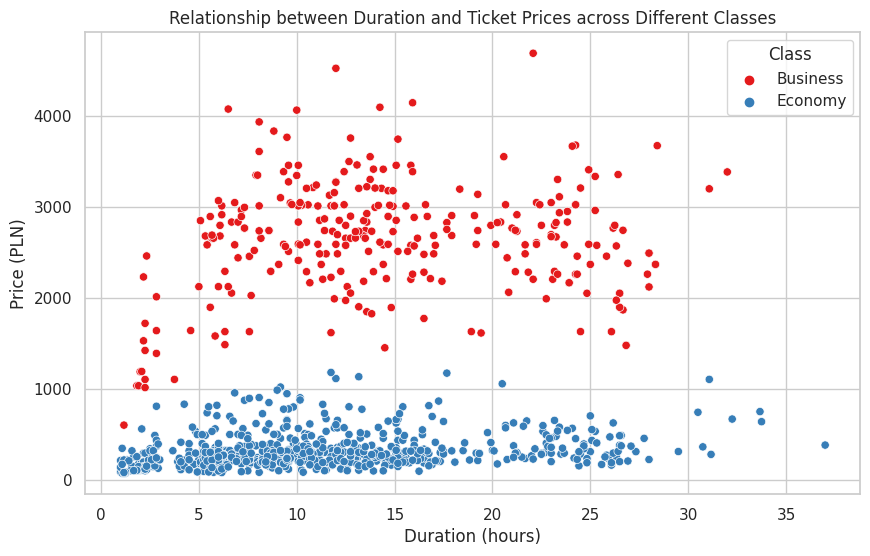

In [ ]:
df_sample = df.sample(n=1000)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='price_pln', hue='class', data=df_sample, palette='Set1')
plt.title('Relationship between Duration and Ticket Prices across Different Classes')
plt.xlabel('Duration (hours)')
plt.ylabel('Price (PLN)')
plt.legend(title='Class')
plt.show()

From the data sample on the chart, it's evident that flight duration has a significantly lesser impact on the price than the class. However, one can notice that as the flight duration increases, prices rise up to a certain point and then decrease. This is probably because longer flights cover greater distances, whereas flights lasting several dozen hours are likely flights with multiple layovers, which are inconvenient for passengers.

<ipython-input-185-a5b84ec904ff>:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.catplot(data=df_sample_2, x="class", y="price_pln", order=["Business", "Economy"], palette='pastel')


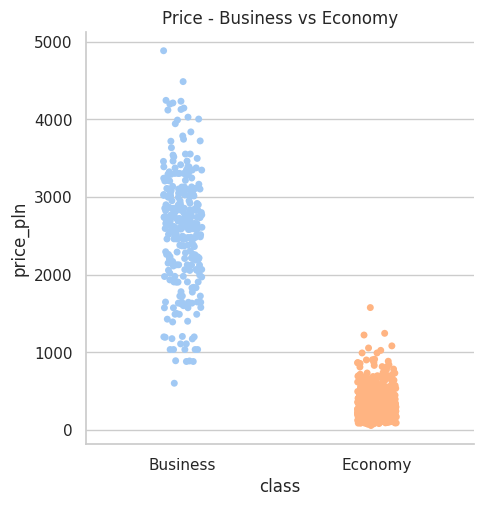

In [ ]:
df_sample_2 = df.sample(n=1000)
sns.catplot(data=df_sample_2, x="class", y="price_pln", order=["Business", "Economy"], palette='pastel')
plt.title("Price - Business vs Economy")
plt.show()

This simple chart, based on a data sample, shows a significant price difference between classes and a much larger price dispersion for business class tickets

## Flight price prediction

In [ ]:
# Feature categorization
num_features = ['duration', 'days_left']
cat_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

In [ ]:
# Preprocessing pipelines
num_pipe = Pipeline([
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("encoder", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num_branch", num_pipe, num_features),
    ("cat_branch", cat_pipe, cat_features)
], remainder="drop")

In [ ]:
# Splitting the data
X = df.drop(["price_pln"], axis=1)
y = df["price_pln"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# List of models to evaluate
models = [
    ("Gradient Boosting", GradientBoostingRegressor()),
    ("XGBoost", XGBRegressor()),
    ("LightGBM", LGBMRegressor())
]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Results for Gradient Boosting:
Score: 0.9534
Mean Squared Error: 59917.898560679554
Root Mean Squared Error (RMSE): 244.78132804746272
Mean Absolute Error: 144.59680103376155


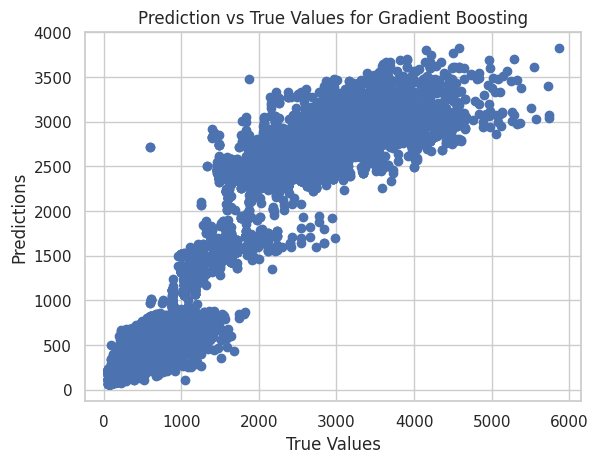

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Results for XGBoost:
Score: 0.9769
Mean Squared Error: 29633.16326460079
Root Mean Squared Error (RMSE): 172.14285714080845
Mean Absolute Error: 97.64731281938583


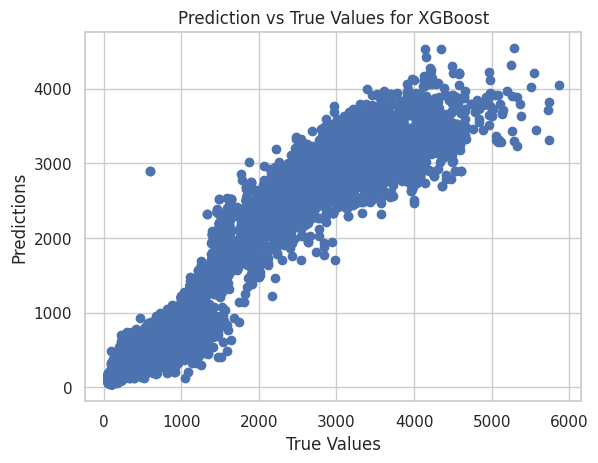

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2631
[LightGBM] [Info] Number of data points in the train set: 240127, number of used features: 1165
[LightGBM] [Info] Start training from score 1044.776218


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Results for LightGBM:
Score: 0.9746
Mean Squared Error: 32586.143798363657
Root Mean Squared Error (RMSE): 180.51632557296213
Mean Absolute Error: 105.89921761345009


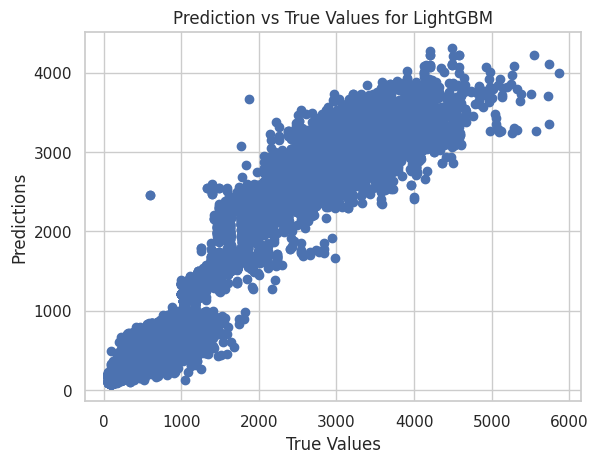

In [ ]:
# Iterating through models
for name, model in models:
    # Creating a pipeline for each model
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Training the model
    pipeline.fit(X_train, y_train)

    # Predicting and evaluating the model
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    score = pipeline.score(X_test, y_test)

    # Displaying results
    print(f"Results for {name}:")
    print(f"Score: {score:.4f}")
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error: {mae}")
    plt.scatter(y_test, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"Prediction vs True Values for {name}")
    plt.show()

All models performed relatively well in predicting the price; the model with the lowest error is XGBoost. A separate Random Forest model will be trained because it is the most advanced and time-consuming to train.

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Results for Random Forest:
Score: 0.9891
Mean Squared Error: 14045.263927248981
Root Mean Squared Error (RMSE): 118.51271631031406
Mean Absolute Error: 43.12786080535588


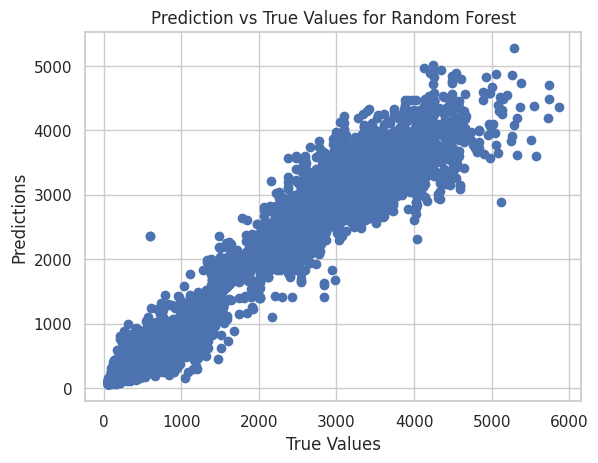

In [ ]:
# Creating the Random Forest model
model = RandomForestRegressor()

# Creating the pipeline for Random Forest
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", model)
])

# Training the model
pipeline.fit(X_train, y_train)

# Storing the trained Random Forest model for later reference
trained_rf_model = pipeline.named_steps['model']

# Predicting and evaluating the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
score = pipeline.score(X_test, y_test)

# Displaying the results
print(f"Results for Random Forest:")
print(f"Score: {score:.4f}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error: {mae}")
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Prediction vs True Values for Random Forest")
plt.show()

The Random Forest model is the best model for predicting ticket price. The results have the smallest error and the highest score.

### This errors is result of big number flight numbers so in test data couldn't be all flight numbers
"/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn("

In [ ]:
# Creating a new dataframe with X_test data
df_new = X_test.copy()

# Adding the true values and predictions as new columns
df_new['True Values'] = y_test
df_new['Predictions'] = y_pred

Table created to visualization of prediction for best model - Random Forrest.

In [ ]:
df_new.head(20)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,True Values,Predictions
192128,Air India,AI-9894,Chennai,Morning,one,Morning,Mumbai,Economy,25.67,35,297.50,309.0360
197468,Indigo,6E-327,Chennai,Morning,zero,Afternoon,Bangalore,Economy,1.00,45,72.15,72.3650
45815,Vistara,UK-810,Bangalore,Early_Morning,one,Afternoon,Mumbai,Business,8.00,45,3350.20,3350.2000
45130,Air India,AI-625,Mumbai,Morning,one,Night,Delhi,Economy,13.42,13,491.40,510.8775
151966,Indigo,6E-7561,Kolkata,Early_Morning,two_plus,Evening,Chennai,Economy,9.67,42,208.50,204.6395
162730,Air India,AI-559,Hyderabad,Early_Morning,one,Night,Mumbai,Economy,15.08,30,263.95,255.6280
201446,Indigo,6E-796,Chennai,Night,one,Morning,Kolkata,Economy,11.08,37,359.40,233.5040
3666,Air India,AI-542,Delhi,Morning,one,Morning,Mumbai,Economy,23.92,20,191.55,186.3125
185756,Indigo,6E-6006,Chennai,Afternoon,one,Late_Night,Delhi,Economy,9.33,37,290.15,284.8385
153432,Vistara,UK-894,Hyderabad,Evening,one,Afternoon,Delhi,Economy,18.17,10,574.40,562.3320


The table shows that the Random Forest model predicts ticket prices with fairly high accuracy.

# Conclusions:
- The Random Forest model is the most effective in predicting prices, but its training time took as long as 1 hour.
- The class of the flight has the greatest influence on the ticket price; the number of stopovers and the number of days to the flight also play a significant role.
- The cheapest ticket will be in the economy class, with more than 2 stopovers, and a distant flight date.
- On the other hand, the most expensive will be a flight in business class, with one stopover and 2 days to the flight.
- Prices are more varied in business class.
- Only 2 airlines offer business class, so the price differences in economy class are more interesting in the analysis.
- Vistara and Air India are the most expensive airlines - they are the only ones with business class, but even in economy class, their tickets are the most expensive.